#Yeimy Andrea Cano Montaño
Código: 202213304

y.cano@uniandes.edu.co


# Algorítmo de Q-Learning

En este ejercicio vamos a probar el algorítmo de Q-learning como un representatnte de los métodos off-policy. Nuestro objetivo, es evaluar el algoritmo sobre distintos ambientes. Para cada uno de los ambientes deben ejecutar un agente de Q-learning en el ambiente, evaluar su ejecución y validar la efectividad del aprendizaje del agente entrenado sobre el ambiente.




In [47]:
class Environment:
    def __init__(self):
        self.board = [False for x in range(0, 5)]
        self.board[4] = True
    
    def start(self):
        return 0
    
    def end(self): 
        return len(self.board)    

In [48]:
import numpy as np
import random
class Learner:
    def __init__(self, agent, env, alpha=0.1, gamma=0.6, epsilon=0.1):
        #hyper parameters
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.environment = env
        self.agent = agent          #actual agent
        self.qtable = self.__initdic__() #rewards table
    
    def __initdic__(self):
        table = dict()
        for i in range(0, self.environment.end()):
            table[i] = np.zeros(len(self.agent.actions))
        return table

    def run(self):
        done = False
        while not done:
            current_state = self.agent.state
            if random.uniform(0,1) < self.epsilon:
                action = self.randomAction()
            else:
                action = np.argmax(self.qtable[current_state]) 
            next_state, reward, done, info = self.step(action)
            old_value = self.qtable[current_state][action]
            next_max = np.max(self.qtable[next_state])
            new_value = (1 - self.alpha)*old_value + self.alpha*(reward + self.gamma*next_max)
            self.qtable[current_state][action] = new_value

            print(info)
            print(f'{current_state}, {action}, {next_state}')

    def randomAction(self):
        return random.randint(0,len(self.agent.actions)-1)

    def step(self, action):
        old_state = self.agent.state
        reward, done = self.getRewards(old_state, self.agent.getAction(action))
        self.agent.action(action)
        next_state = self.agent.state
        info = f'Executed action: {self.agent.getAction(action)} at state {old_state}'
        return next_state, reward, done, info

    def getRewards(self, state, action):
        if state == self.environment.end() - 2 and action == 'right':
            return 10, True
        else:
            return 0, False

In [49]:
import random

class Agent:
    def __init__(self, rb):
        self.state = 0
        self.actions = [0,1]
        self.rightBound = rb - 1

    def forward(self):
        self.state = min(self.state + 1, self.rightBound)
        
    def back(self):
        self.state = max(self.state - 1, 0)
        
    def action(self, action : int):
        if action:
            self.forward()
        else:
            self.back()
    
    def getAction(self, action : int):
        if action:
            return 'right'
        else:
            return 'left'
    
    def reset(self):
        self.state = 0  

In [50]:
episodes = 10
e = Environment()
a = Agent(e.end())
l = Learner(a, e)
for i in range(0, episodes):
    print(f"Episode: {i+1}")
    l.run()
    a.reset()

Se han truncado las últimas 5000 líneas del flujo de salida.
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: right at state 0
0, 1, 1
Executed action: left at state 1
1, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at state 0
0, 0, 0
Executed action: left at sta

In [51]:
l.qtable

{0: array([1.29600000e-05, 2.76376285e-02]),
 1: array([0.        , 0.25268698]),
 2: array([0.        , 1.58340643]),
 3: array([0.       , 6.5132156]),
 4: array([0., 0.])}

## Gridworld

Sobre el ambiente de Gridworld que hemos venido utilizando, ejecute el algoritmo de Q-learning. Debe ejecutar el algoritmo hasta su convergencia y entregar tanto la política resultado y la Q-tabla.


In [96]:
import numpy as np
from collections import defaultdict
from tabulate import tabulate

class GridWorld:    
  def __init__(self, dimensions:tuple=(4,4), start_state=(0,0), goal_state=(3,3), blocked_states=[(2, 2)], reward_neg={}):
    self.dimensions = dimensions
    self.height = self.dimensions[0]
    self.width = self.dimensions[1] 
    self.board = [[0 for _ in range(self.width)] for _ in range(self.height)]

    self.start_state = start_state
    self.goal_state = goal_state
    self.blocked_states = blocked_states
    self.reward_neg = reward_neg
    self.states = [(x,y) for x in range(self.width) for y in range(self.height)]

    #Definir 1 para la celda de salida
    self.board[self.goal_state[0]][self.goal_state[1]] = 1
    #setear recompensas negativas
    for key,value in reward_neg.items():
        self.board[key[0]][key[1]] = value
    #setear celdas bloqueadas
    for i,j in blocked_states:
        self.set_obstacle(i, j)

  def set_obstacle(self, row, column):
      self.board[row][column] = '*'
        
  def set_reward(self, row, column, reward):
      self.board[row][column] = reward
                                                                
  def print_board(self):
    table = []
    for i in range(len(self.board)):
        row = []
        for j in range(len(self.board[i])):
            cell = str(self.board[i][j])
            width = len(cell)
            row.append('{:^{}}'.format(cell, width))
        table.append(row)
    print(tabulate(table, tablefmt='fancy_grid'))

  def reset(self):
    self.current_state = (0,0)

  def is_terminal(self):
    return self.goal_state == (self.current_state[0], self.current_state[1])  

In [97]:
class Q_Agent():
    def __init__(self, environment):
      self.environment = environment
      #self.start_state = self.environment.start_state
      #self.goal_state = self.environment.goal_state
      self.status = [[0 for _ in range(self.environment.width)] for _ in range(self.environment.height)]
      self.current_state = self.environment.start_state

      #self.actions = {'up': (-1,0), 'down': (1,0), 'left': (0,-1), 'right': (0,1)}
      self.actions = {'up', 'down', 'left', 'right'}

    def get_current_state(self):
        return self.current_state

    def get_possible_actions(self, state):
        i, j = state
        actions = []
        if i > 0 and self.environment.board[i-1][j] != '*':
            actions.append('up')
        if i < self.environment.height-1 and self.environment.board[i+1][j] != '*':
            actions.append('down')
        if j > 0 and self.environment.board[i][j-1] != '*':
            actions.append('left')
        if j < self.environment.width -1 and self.environment.board[i][j+1] != '*':
          actions.append('right')
        return actions

    def do_action(self, action):
        i, j = self.current_state
        if action == 'up':
            i -= 1
        elif action == 'down':
            i += 1
        elif action == 'left':
            j -= 1
        elif action == 'right':
            j += 1
        self.current_state = (i, j)
        return self.current_state
        
    def reset(self):
        self.current_state = (0, 0)
    
    def random_reset(self):
        self.current_state = (random.randint(0, self.environment.height-1), random.randint(0, self.environment.width -1))
        while self.current_state in self.environment.blocked_states:
          self.current_state = (random.randint(0, self.environment.height-1), random.randint(0, self.environment.width -1))
        print('new start state:', self.current_state)

In [98]:
class Q_Learning:
  def __init__(self, environment, agent, epsilon=0.05, alpha=0.1, gamma=1):
    self.environment = environment
    self.agent = agent
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma

    self.q_table = dict() 
    #incializar q_table en cero
    for x in range(self.environment.height): 
        for y in range(self.environment.width):
            self.q_table[(x,y)] = {'up':0, 'down':0, 'left':0, 'right':0}
    #asignar Nan cuando no es posible la accion
    for i in range(self.environment.height):
      self.q_table[(i, self.environment.width -1)]['right'] = np.nan
      self.q_table[(i, 0)]['left'] = np.nan
    for i in range(self.environment.width):
      self.q_table[(self.environment.height -1, i)]['down'] = np.nan
      self.q_table[(0, i)]['up'] = np.nan
    for block in self.environment.blocked_states:
      i, j = block
      if i > 0:
        self.q_table[(i-1, j)]['down'] = np.nan
      if i < self.environment.height - 1:
        self.q_table[(i+1, j)]['up'] = np.nan
      if j > 0:
        self.q_table[(i, j-1)]['right'] = np.nan
      if j < self.environment.width - 1:
        self.q_table[(i, j+1)]['left'] = np.nan
    #if (0, 0) in self.environment.blocked_states:
    #  self.q_table[(0, 0)] = {action: np.nan for action in self.agent.actions}

    
  def run(self):
    done = False
    while not done:
      current_state = self.agent.current_state
      available_actions = self.agent.get_possible_actions(current_state)
      action = self.choose_action(available_actions)
      next_state, reward, done = self.step(current_state, action)
      old_value = self.q_table[current_state][action]
      next_max = max(v for v in self.q_table[next_state].values() if not np.isnan(v))
      self.q_table[current_state][action] = (1 - self.alpha)*old_value + self.alpha*(reward + self.gamma*next_max)
      print(f'state: {current_state}, action: {action}, next_sate:{next_state}')

  def choose_action(self, available_actions):
      """Devuelve la acción óptima de la tabla Q-Value siguiendo E-greedy"""
      if np.random.uniform(0,1) < self.epsilon:
          action = available_actions[np.random.randint(0, len(available_actions))]
      else:
          q_values_of_state = self.q_table[self.agent.current_state]
          possible_actions = [k for k in q_values_of_state.keys() if k in available_actions]
          maxValue = max(filter(lambda x: x is not np.nan, [q_values_of_state[k] for k in possible_actions]))
          action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue and k in possible_actions])
      return action
      
  def step(self, old_state, action):
    next_state = self.agent.do_action(action)
    reward, done = self.getRewards(next_state)
    return next_state, reward, done
  
  def getRewards(self, state):
    reward = self.environment.board[state[0]][state[1]] - 1 #El valor del grid restando 1 por hacer el movimiento
    if state == self.environment.goal_state:
      done = True
    else:
      done = False
    return reward, done

  def get_policy(self):
    policy = {}
    table = []
    for state, actions in self.q_table.items():
        if state in self.environment.blocked_states:
            continue
        best_action = max((v, k) for k, v in actions.items() if not np.isnan(v))[1]
        policy[state] = best_action
    for i in range(len(self.environment.board)):
        row = []
        for j in range(len(self.environment.board[i])):
          state = (i, j)
          if state in self.environment.blocked_states:
            cell = '*'
          elif state == self.environment.goal_state:
            cell = 'goal'
          else:
            cell = str(policy[i, j])
          width = len(cell)
          row.append('{:^{}}'.format(cell, width))
        table.append(row)
    print(tabulate(table, tablefmt='fancy_grid'))

In [99]:
env = GridWorld(dimensions=(10, 10), start_state=(0,0), goal_state=(5,5), 
                blocked_states=[(2, 1), (2, 2), (2, 3), (2, 4) ,(2, 6) ,(2, 7) ,(2, 8) ,(3, 4) ,(4, 4) ,(5, 4) ,(6, 4),(7, 4)], 
                reward_neg={(4, 5): -1, (7, 5): -1, (7, 6): -1})

env.print_board()

╒═══╤═══╤═══╤═══╤═══╤════╤════╤═══╤═══╤═══╕
│ 0 │ 0 │ 0 │ 0 │ 0 │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ 0 │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ * │ * │ * │ * │  0 │ *  │ * │ * │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │ -1 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │  1 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │ -1 │ -1 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ 0 │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ 0 │  0 │ 0  │ 0 │ 0 │ 0 │
╘═══╧═══╧═══╧═══╧═══╧════╧════╧═══╧═══╧═══╛


In [100]:
agent = Q_Agent(env)
l = Q_Learning(env, agent, epsilon=0.05, alpha=0.1, gamma=1)

In [101]:
episodes = 3000
for i in range(0, episodes):
    print(f"Episode: {i+1}")
    l.run()
    agent.reset()

Se han truncado las últimas 5000 líneas del flujo de salida.
state: (0, 5), action: down, next_sate:(1, 5)
state: (1, 5), action: down, next_sate:(2, 5)
state: (2, 5), action: down, next_sate:(3, 5)
state: (3, 5), action: down, next_sate:(4, 5)
state: (4, 5), action: down, next_sate:(5, 5)
Episode: 2578
state: (0, 0), action: right, next_sate:(0, 1)
state: (0, 1), action: right, next_sate:(0, 2)
state: (0, 2), action: down, next_sate:(1, 2)
state: (1, 2), action: right, next_sate:(1, 3)
state: (1, 3), action: right, next_sate:(1, 4)
state: (1, 4), action: right, next_sate:(1, 5)
state: (1, 5), action: down, next_sate:(2, 5)
state: (2, 5), action: down, next_sate:(3, 5)
state: (3, 5), action: down, next_sate:(4, 5)
state: (4, 5), action: down, next_sate:(5, 5)
Episode: 2579
state: (0, 0), action: right, next_sate:(0, 1)
state: (0, 1), action: right, next_sate:(0, 2)
state: (0, 2), action: right, next_sate:(0, 3)
state: (0, 3), action: right, next_sate:(0, 4)
state: (0, 4), action: down,

###Q-table del gridworld


In [102]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def print_qtable(q_table):
  lista = []
  for estado, valores in q_table.items():
      tupla = (estado,) + tuple(valores.values())
      lista.append(tupla)

  dataframe = pd.DataFrame(lista, columns=['estado', 'up', 'down', 'left', 'right'])
  return dataframe
  

In [103]:
qt = print_qtable(l.q_table)
qt

,estado,up,down,left,right
0,"(0, 0)",NaN,-10.000000,NaN,-10.000000
1,"(0, 1)",NaN,-9.000000,-10.924140,-9.000000
2,"(0, 2)",NaN,-8.000000,-9.843644,-8.000000
3,"(0, 3)",NaN,-7.000000,-8.664631,-7.000000
4,"(0, 4)",NaN,-6.000000,-7.230634,-6.000000
5,"(0, 5)",NaN,-5.000000,-6.227551,-5.237236
6,"(0, 6)",NaN,-4.903181,-5.010779,-4.967785
7,"(0, 7)",NaN,-4.672139,-4.732203,-4.654696
8,"(0, 8)",NaN,-4.342880,-4.437222,-4.482698
9,"(0, 9)",NaN,-4.214765,-4.230529,NaN


###Policy del gridworld

In [104]:
#grafico del ambiente
env.print_board()

╒═══╤═══╤═══╤═══╤═══╤════╤════╤═══╤═══╤═══╕
│ 0 │ 0 │ 0 │ 0 │ 0 │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ 0 │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ * │ * │ * │ * │  0 │ *  │ * │ * │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │ -1 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │  1 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ * │ -1 │ -1 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ 0 │  0 │ 0  │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼────┼────┼───┼───┼───┤
│ 0 │ 0 │ 0 │ 0 │ 0 │  0 │ 0  │ 0 │ 0 │ 0 │
╘═══╧═══╧═══╧═══╧═══╧════╧════╧═══╧═══╧═══╛


In [105]:
#politica del ambiente:
l.get_policy()

╒═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤══════╕
│ right │ right │ right │ right │ right │ down  │ down  │ right │ down  │ down │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼──────┤
│ right │ right │ right │ right │ right │ down  │ left  │ up    │ right │ up   │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼──────┤
│ down  │ *     │ *     │ *     │ *     │ down  │ *     │ *     │ *     │ down │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼──────┤
│ right │ right │ down  │ left  │ *     │ down  │ down  │ down  │ left  │ down │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼──────┤
│ down  │ down  │ left  │ left  │ *     │ down  │ down  │ down  │ left  │ left │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼──────┤
│ down  │ left  │ down  │ up    │ *     │ goal  │ left  │ left  │ left  │ up   │
├───────┼───────┼───────┼───

## Laberinto de cuartos 

El ambiente del laberinto de cuartos consiste en una cuadricula con 4 cuartos como se muestra a continuación.

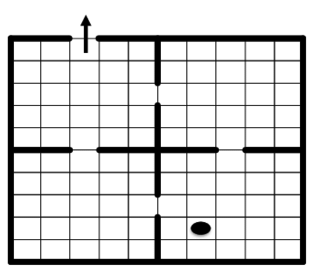

Para este ambiente queremos que el agente aprenda a salir por el cuarto superior izquierdo en la menor cantidad de pasos posible. La única restricción de este ambiente es que al final de cada episodio el agente comienza nuevamente en cualquier posicón valida del laberinto. Usted debe definir los parametros ($\alpha, \gamma, \epsilon$, recompensa) para asegurar el comportamiento del agente


In [62]:
#definir el ambiente laberinto de cuartos
mazeRooms = GridWorld(dimensions=(13, 13), start_state=(10,9), goal_state=(0,3), 
                blocked_states=[(0,0), (0,1), (0,2), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9), (0,10), (0,11), (0,12),\
                                (6,0), (6,1), (6,2), (6,4), (6,5), (6,6), (6,7), (6,8), (6,10), (6,11), (6,12),\
                                (12,0), (12,1), (12,2), (12,3), (12,4), (12,5), (12,6), (12,7), (12,8), (12,9), (12,10), (12,11), (12,12),\
                                (1,0), (2,0), (3,0), (4,0), (5,0), (6,0), (7,0), (8,0), (9,0), (10,0), (11,0), (12,0),\
                                (0,6), (1,6), (2,6), (4,6), (5,6), (6,6), (7,6), (8,6), (10,6), (11,6), (12,6),\
                                (0,12), (1,12), (2,12), (3,12), (4,12), (5,12), (6,12), (7,12), (8,12), (9,12), (10,12), (11,12), (12,12)\
                                ])
#Asignar recompensa de +10 para la celda de salida:
mazeRooms.set_reward(0, 3, 10)
#Asignar recompensa de +2 y +1 para llegar al cuarto de salida
mazeRooms.set_reward(1, 3, 2)
mazeRooms.set_reward(2, 3, 1)
mazeRooms.set_reward(3, 3, 1)
mazeRooms.print_board()

╒═══╤═══╤═══╤════╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ * │ * │ * │ 10 │ * │ * │ * │ * │ * │ * │ * │ * │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 2  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 1  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 1  │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 0  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 0  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ * │ * │ 0  │ * │ * │ * │ * │ * │ 0 │ * │ * │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 0  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 0  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼─

Para este caso, se define:

* α: 0.1
* γ: 0.9
* ϵ: 0.1
* recompensa: +10 para llegar a la salida, y +2 para las puertas que se comunican con el cuarto de salida.


In [63]:
agent_maze = Q_Agent(mazeRooms)
learn_maze = Q_Learning(mazeRooms, agent_maze, epsilon=0.1, alpha=0.1, gamma=0.9)

In [64]:
episodes = 700
for i in range(0, episodes):
    print(f"Episode: {i+1}")
    learn_maze.run()
    # al final de cada episodio el agente comienza nuevamente en cualquier posicón valida del laberinto
    agent_maze.random_reset()

Se han truncado las últimas 5000 líneas del flujo de salida.
state: (3, 3), action: up, next_sate:(2, 3)
state: (2, 3), action: up, next_sate:(1, 3)
state: (1, 3), action: up, next_sate:(0, 3)
new start state: (5, 7)
Episode: 350
state: (5, 7), action: up, next_sate:(4, 7)
state: (4, 7), action: up, next_sate:(3, 7)
state: (3, 7), action: left, next_sate:(3, 6)
state: (3, 6), action: left, next_sate:(3, 5)
state: (3, 5), action: left, next_sate:(3, 4)
state: (3, 4), action: left, next_sate:(3, 3)
state: (3, 3), action: up, next_sate:(2, 3)
state: (2, 3), action: up, next_sate:(1, 3)
state: (1, 3), action: up, next_sate:(0, 3)
new start state: (1, 2)
Episode: 351
state: (1, 2), action: right, next_sate:(1, 3)
state: (1, 3), action: up, next_sate:(0, 3)
new start state: (4, 4)
Episode: 352
state: (4, 4), action: up, next_sate:(3, 4)
state: (3, 4), action: left, next_sate:(3, 3)
state: (3, 3), action: right, next_sate:(3, 4)
state: (3, 4), action: left, next_sate:(3, 3)
state: (3, 3), act

###Q-table del laberinto de cuartos.


In [65]:
lm = print_qtable(learn_maze.q_table)
lm

       estado         up      down       left      right
0      (0, 0)        NaN       NaN        NaN        NaN
1      (0, 1)        NaN  0.000000        NaN        NaN
2      (0, 2)        NaN  0.000000        NaN   0.000000
3      (0, 3)        NaN  5.105315        NaN        NaN
4      (0, 4)        NaN  0.000000   0.000000        NaN
5      (0, 5)        NaN  0.000000        NaN        NaN
6      (0, 6)        NaN       NaN        NaN        NaN
7      (0, 7)        NaN  0.000000        NaN        NaN
8      (0, 8)        NaN  0.000000        NaN        NaN
9      (0, 9)        NaN  0.000000        NaN        NaN
10    (0, 10)        NaN  0.000000        NaN        NaN
11    (0, 11)        NaN  0.000000        NaN        NaN
12    (0, 12)        NaN       NaN        NaN        NaN
13     (1, 0)        NaN       NaN        NaN   0.000000
14     (1, 1)        NaN -0.100000        NaN   5.233928
15     (1, 2)        NaN  1.062273   0.464513  11.396498
16     (1, 3)  13.593697  7.604

###Policy del laberinto de cuartos

In [66]:
#Gráfico del ambiente
mazeRooms.print_board()

╒═══╤═══╤═══╤════╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ * │ * │ * │ 10 │ * │ * │ * │ * │ * │ * │ * │ * │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 2  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 1  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 1  │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 0  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 0  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ * │ * │ 0  │ * │ * │ * │ * │ * │ 0 │ * │ * │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 0  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼───┼────┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ * │ 0 │ 0 │ 0  │ 0 │ 0 │ * │ 0 │ 0 │ 0 │ 0 │ 0 │ * │
├───┼───┼─

In [67]:
#Política de acuerdo a q-table
learn_maze.get_policy()

╒═══╤═══════╤═══════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤══════╤══════╤═══╕
│ * │ *     │ *     │ goal │ *    │ *    │ *    │ *     │ *     │ *     │ *    │ *    │ * │
├───┼───────┼───────┼──────┼──────┼──────┼──────┼───────┼───────┼───────┼──────┼──────┼───┤
│ * │ right │ right │ up   │ left │ left │ *    │ down  │ down  │ down  │ down │ down │ * │
├───┼───────┼───────┼──────┼──────┼──────┼──────┼───────┼───────┼───────┼──────┼──────┼───┤
│ * │ right │ right │ up   │ left │ down │ *    │ down  │ down  │ down  │ down │ up   │ * │
├───┼───────┼───────┼──────┼──────┼──────┼──────┼───────┼───────┼───────┼──────┼──────┼───┤
│ * │ right │ right │ up   │ left │ left │ left │ left  │ left  │ left  │ left │ left │ * │
├───┼───────┼───────┼──────┼──────┼──────┼──────┼───────┼───────┼───────┼──────┼──────┼───┤
│ * │ right │ right │ up   │ up   │ up   │ *    │ up    │ up    │ left  │ left │ left │ * │
├───┼───────┼───────┼──────┼──────┼──────┼──────┼───────┼───────┼───────┼──────┼

## Taxi

El ambiente de taxi consiste en una cuadrícula de `5x5`, con 4 estaciones (`R`, `G`,`Y`, `B`), como se muestra en la figura. El taxi puede moverse libremente entre las casillas de la cuadrícula. sin embargo, no puede atravesar por los separadores (las lines más gruesas en la figura).

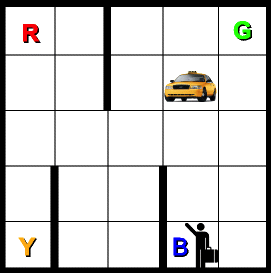

El taxi (i.e., el agente) se mueve por el ambiente buscando recoger un pasajero. Los pasajeros aparecen aleatoriamente en alguno de los paraderos (uno a la vez) y deben llegar a su destino (algún otro paradero).

Las acciones del agente corresponden a los movimientos del agente en el tablero y las acciones para recoger y dejar pasajeros. 
Tratar de recoger o dejar un pasajero en un lugar indebido o cuando no hay pasajero, son consideradas malas accciones del agente y deben ser penalizadas (tienen una recompenza de -10). Para asegurar que el agente efectivamente recoge pasajeros, debemos darle una recompensa de 1 a la acción. Efectivamente dejar al pasajero tiene una recompensa de 5. 

Implemente el algoritmo de Q-learning (defina sus propios parámetros) para el aprendizaje del agente.

In [157]:
class Taxi_Env:    
  def __init__(self, dimensions:tuple=(5,8), blocked_states=[(2, 2)], stations={}):
    self.dimensions = dimensions
    self.height = self.dimensions[0]
    self.width = self.dimensions[1] 
    self.board = [[' ' for _ in range(self.width)] for _ in range(self.height)]
    self.blocked_states = blocked_states
    self.stations = stations
    self.states = [(x,y) for x in range(self.width) for y in range(self.height)]

    #definir aleatoriamente inicio y destino del pasajero
    keys = list(self.stations.keys())
    random.shuffle(keys)
    self.start_state = keys[0]
    self.goal_state = self.start_state
    while self.goal_state == self.start_state :
        self.goal_state = keys[1]

    #setear estaciones
    for key in self.stations.keys():
      i,j = key
      self.board[i][j] = self.stations[(i,j)]
    #setear celdas bloqueadas
    for i,j in blocked_states:
        self.set_obstacle(i, j)

  def set_obstacle(self, row, column):
      self.board[row][column] = '*'
                                                                
  def print_board(self):
    table = []
    for i in range(len(self.board)):
        row = []
        for j in range(len(self.board[i])):
            cell = str(self.board[i][j])
            width = len(cell)
            row.append('{:^{}}'.format(cell, width))
        table.append(row)
    print(tabulate(table, tablefmt='fancy_grid'))

  def reset(self):
    self.current_state = (0,0)

  def is_terminal(self):
    return self.goal_state == (self.current_state[0], self.current_state[1])  

In [122]:
class Q_Taxi_Agent():
    def __init__(self, environment):
      self.environment = environment
      self.status = [[0 for _ in range(self.environment.width)] for _ in range(self.environment.height)]
      self.actions = {'up', 'down', 'left', 'right', 'pickup', 'dropoff'}
      self.passenger_pickup = False 
      self.passenger_dropoff = False
      self.pickup = 0

      #inicio aleatorio del agente-taxi
      self.current_state = (random.randint(0, self.environment.height-1), random.randint(0, self.environment.width -1))
      while self.current_state in self.environment.blocked_states:
        self.current_state = (random.randint(0, self.environment.height-1), random.randint(0, self.environment.width -1))

    def get_current_state(self):
        return self.current_state

    def get_possible_actions(self, state):
        i, j = state
        actions = []
        if state in self.environment.stations:
            actions.append('dropoff')
            actions.append('pickup')
        if i > 0 and self.environment.board[i-1][j] != '*':
            actions.append('up')
        if i < self.environment.height-1 and self.environment.board[i+1][j] != '*':
            actions.append('down')
        if j > 0 and self.environment.board[i][j-1] != '*':
            actions.append('left')
        if j < self.environment.width -1 and self.environment.board[i][j+1] != '*':
          actions.append('right')
        return actions

    def do_action(self, action):
        i, j = self.current_state
        if action == 'up':
            i -= 1
        elif action == 'down':
            i += 1
        elif action == 'left':
            j -= 1
        elif action == 'right':
            j += 1
        elif action == 'pickup' and self.current_state==self.environment.start_state:
            self.passenger_pickup = True
        elif action == 'dropoff' and self.current_state==self.environment.goal_state:
            self.passenger_dropoff = True
        self.current_state = (i, j)
        return self.current_state
        
    def reset(self):
        self.passenger_pickup = False 
        self.passenger_dropoff = False 
        self.current_state = (random.randint(0, self.environment.height-1), random.randint(0, self.environment.width -1))
        while self.current_state in self.environment.blocked_states:
          self.current_state = (random.randint(0, self.environment.height-1), random.randint(0, self.environment.width -1))
        print('new start state:', self.current_state)

In [123]:
class Q_Taxi_Learning:
  def __init__(self, environment, agent, epsilon=0.05, alpha=0.1, gamma=1):
    self.environment = environment
    self.agent = agent
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma

    self.q_table = dict() 
    #incializar q_table en cero
    for x in range(self.environment.height): 
        for y in range(self.environment.width):
            self.q_table[(x,y)] = {'up':0, 'down':0, 'left':0, 'right':0, 'pickup':0, 'dropoff':0}
    #asignar Nan cuando no es posible la accion
    for i in range(self.environment.height):
      self.q_table[(i, self.environment.width -1)]['right'] = np.nan
      self.q_table[(i, 0)]['left'] = np.nan
    for i in range(self.environment.width):
      self.q_table[(self.environment.height -1, i)]['down'] = np.nan
      self.q_table[(0, i)]['up'] = np.nan
    for block in self.environment.blocked_states:
      i, j = block
      if i > 0:
        self.q_table[(i-1, j)]['down'] = np.nan
      if i < self.environment.height - 1:
        self.q_table[(i+1, j)]['up'] = np.nan
      if j > 0:
        self.q_table[(i, j-1)]['right'] = np.nan
      if j < self.environment.width - 1:
        self.q_table[(i, j+1)]['left'] = np.nan
    
  def run(self):
    done = False
    while not done:
      current_state = self.agent.current_state
      available_actions = self.agent.get_possible_actions(current_state)
      action = self.choose_action(available_actions)
      next_state, reward, done = self.step(current_state, action)
      old_value = self.q_table[current_state][action]
      next_max = max(v for v in self.q_table[next_state].values() if not np.isnan(v))
      self.q_table[current_state][action] = (1 - self.alpha)*old_value + self.alpha*(reward + self.gamma*next_max)
      print(f'state: {current_state}, action: {action}, next_sate:{next_state}')

  def choose_action(self, available_actions):
      """Devuelve la acción óptima de la tabla Q-Value siguiendo E-greedy"""
      if np.random.uniform(0,1) < self.epsilon:
          action = available_actions[np.random.randint(0, len(available_actions))]
      else:
          q_values_of_state = self.q_table[self.agent.current_state]
          possible_actions = [k for k in q_values_of_state.keys() if k in available_actions]
          maxValue = max(filter(lambda x: x is not np.nan, [q_values_of_state[k] for k in possible_actions]))
          action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue and k in possible_actions])
      return action
      
  def step(self, old_state, action):
    old_passanger_state_dropoff = self.agent.passenger_dropoff
    next_state = self.agent.do_action(action)
    reward, done = self.getRewards(action, next_state)
    return next_state, reward, done
  
  def getRewards(self, action, state):
    #reward = - 1 #-1 por moverse
    reward = 0
    
    if action == 'pickup': 
      if state==self.environment.start_state:
        reward += 1
      else:
        reward += -10

    if action == 'dropoff': 
      if self.agent.passenger_dropoff == True and state == self.environment.goal_state:
        reward += 5
      else:
        reward += -10

    if state == self.environment.goal_state and self.agent.passenger_pickup == True and self.agent.passenger_dropoff == True: 
      done = True
    else:
      done = False 
    return reward, done

  def get_policy(self):
    policy = {}
    table = []
    for state, actions in self.q_table.items():
        if state in self.environment.blocked_states:
            continue
        best_action = max((v, k) for k, v in actions.items() if not np.isnan(v))[1]
        policy[state] = best_action
    for i in range(len(self.environment.board)):
        row = []
        for j in range(len(self.environment.board[i])):
          state = (i, j)
          if state in self.environment.blocked_states:
            cell = '*'
          else:
            cell = str(policy[i, j])
          width = len(cell)
          row.append('{:^{}}'.format(cell, width))
        table.append(row)
    print(tabulate(table, tablefmt='fancy_grid'))

In [169]:
#definir el ambiente taxi
taxi_env = Taxi_Env(dimensions=(5, 7), 
                blocked_states=[(0,2), (1,2), (3,1), (4,1), (3,4), (4,4)],
                stations={(0, 0): 'R', (0, 6): 'G', (4, 0): 'Y', (4, 6): 'B'})

taxi_env.print_board()
print("ubicación de pasajero", taxi_env.start_state, "=", taxi_env.stations[taxi_env.start_state])
print("destino de pasajero", taxi_env.goal_state, "=", taxi_env.stations[taxi_env.goal_state])

╒═══╤═══╤═══╤══╤═══╤══╤═══╕
│ R │   │ * │  │   │  │ G │
├───┼───┼───┼──┼───┼──┼───┤
│   │   │ * │  │   │  │   │
├───┼───┼───┼──┼───┼──┼───┤
│   │   │   │  │   │  │   │
├───┼───┼───┼──┼───┼──┼───┤
│   │ * │   │  │ * │  │   │
├───┼───┼───┼──┼───┼──┼───┤
│ Y │ * │   │  │ * │  │ B │
╘═══╧═══╧═══╧══╧═══╧══╧═══╛
ubicación de pasajero (0, 6) = G
destino de pasajero (0, 0) = R


In [178]:
taxi_agent = Q_Taxi_Agent(taxi_env)
taxi_learn = Q_Taxi_Learning(taxi_env, taxi_agent, epsilon=0.5, alpha=0.1, gamma=0.9)

In [179]:
episodes = 5
for i in range(0, episodes):
    print(f"Episode: {i+1}")
    taxi_learn.run()
    taxi_agent.reset()

Se han truncado las últimas 5000 líneas del flujo de salida.
state: (0, 6), action: dropoff, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: dropoff, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: pickup, next_sate:(0, 6)
state: (0, 6), action: down, next_sate:(1, 6)
state: (1, 6), action: up, next_sate:(0, 6)
state: (0, 6), action: dropoff, next_sate:(0, 6)
state: (0, 6), action: down, next_sate:(1, 6)
state: (1, 6), action: down, next_sate:(2, 6)
state: (2, 6), action: up, next_sate:(1, 6)
state: (1, 6), action: up, next_sate:(

###Q-table de taxi.

In [180]:
def print_qtable_taxi(q_table):
  lista = []
  for estado, valores in q_table.items():
      tupla = (estado,) + tuple(valores.values())
      lista.append(tupla)

  dataframe = pd.DataFrame(lista, columns=['estado', 'up', 'down', 'left', 'right', 'pickup', 'dropoff'])
  return dataframe
  

In [181]:
qtt = print_qtable_taxi(taxi_learn.q_table)
qtt

,estado,up,down,left,right,pickup,dropoff
0,"(0, 0)",NaN,0.037027,NaN,0.056239,-1.670168,9.513607
1,"(0, 1)",NaN,0.000000,0.807935,NaN,0.000000,0.000000
2,"(0, 2)",NaN,NaN,0.000000,0.000000,0.000000,0.000000
3,"(0, 3)",NaN,5.904900,NaN,7.290000,0.000000,0.000000
4,"(0, 4)",NaN,6.561000,6.561000,8.100000,0.000000,0.000000
5,"(0, 5)",NaN,7.290000,7.290000,9.000000,0.000000,0.000000
6,"(0, 6)",NaN,8.100000,8.100000,NaN,10.000000,-1.000000
7,"(1, 0)",1.121151,0.003800,NaN,0.000000,0.000000,0.000000
8,"(1, 1)",0.000000,0.000000,0.030138,NaN,0.000000,0.000000
9,"(1, 2)",NaN,0.000000,0.000000,0.000000,0.000000,0.000000


###Policy de Taxi

In [182]:
taxi_env.print_board()
print("ubicación de pasajero", taxi_env.start_state, "=", taxi_env.stations[taxi_env.start_state])
print("destino de pasajero", taxi_env.goal_state, "=", taxi_env.stations[taxi_env.goal_state])

╒═══╤═══╤═══╤══╤═══╤══╤═══╕
│ R │   │ * │  │   │  │ G │
├───┼───┼───┼──┼───┼──┼───┤
│   │   │ * │  │   │  │   │
├───┼───┼───┼──┼───┼──┼───┤
│   │   │   │  │   │  │   │
├───┼───┼───┼──┼───┼──┼───┤
│   │ * │   │  │ * │  │   │
├───┼───┼───┼──┼───┼──┼───┤
│ Y │ * │   │  │ * │  │ B │
╘═══╧═══╧═══╧══╧═══╧══╧═══╛
ubicación de pasajero (0, 6) = G
destino de pasajero (0, 0) = R


In [183]:
#Política de acuerdo a q-table
taxi_learn.get_policy()

╒═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╕
│ dropoff │ left  │ *     │ right │ right │ right │ pickup │
├─────────┼───────┼───────┼───────┼───────┼───────┼────────┤
│ up      │ left  │ *     │ up    │ right │ up    │ up     │
├─────────┼───────┼───────┼───────┼───────┼───────┼────────┤
│ right   │ right │ right │ right │ right │ right │ up     │
├─────────┼───────┼───────┼───────┼───────┼───────┼────────┤
│ up      │ *     │ right │ up    │ *     │ right │ up     │
├─────────┼───────┼───────┼───────┼───────┼───────┼────────┤
│ up      │ *     │ up    │ up    │ *     │ right │ up     │
╘═════════╧═══════╧═══════╧═══════╧═══════╧═══════╧════════╛
